In [1]:
#install pyreadr on terminal
! pip install pyreadr lightgbm

     |████████████████████████████████| 364 kB 22.8 MB/s            
     |████████████████████████████████| 2.0 MB 64.7 MB/s            
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import os
from termcolor import colored

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, r2_score, silhouette_score
from sklearn.metrics import confusion_matrix,precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, roc_auc_score

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier 
from sklearn.ensemble import BaggingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN

# Haplotype model - Categorical variable

In [3]:
import pyreadr

# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/dummyMatrix_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [4]:
femaleData.head()

,HB1__1067-1,HB1__32843,HB1__64DWA2,HB1__B73,HB1__MANS,HB1__NA,HB1__WDAQ2,HB2__1067-1,HB2__32843,HB2__64DWA2,...,HB17115__7797,HB17115__B73,HB17115__NA,HB17115__RQAA8,HB17116__2FACC,HB17116__7797,HB17116__B73,HB17116__FBMU,HB17116__NA,HB17116__RQAA8
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [5]:
maleData.head()

,HB1__01HGI4,HB1__610,HB1__B14,HB1__LH287,HB1__M3AG-3,HB1__NA,HB1__OH43AE1,HB1__PH207,HB2__610,HB2__B14,...,HB17114__OH07,HB17114__PH207,HB17115__LH123,HB17115__NA,HB17115__OH07,HB17115__TA1180,HB17116__LH123,HB17116__NA,HB17116__OH07,HB17116__PH207
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [6]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [7]:
maleData.head()

,HB1__01HGI4_m,HB1__610_m,HB1__B14_m,HB1__LH287_m,HB1__M3AG-3_m,HB1__NA_m,HB1__OH43AE1_m,HB1__PH207_m,HB2__610_m,HB2__B14_m,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
LH287,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0
83INI14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
17IFI6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
DILU757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GEJO564,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [8]:
femaleData.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17115__7797_f,HB17115__B73_f,HB17115__NA_f,HB17115__RQAA8_f,HB17116__2FACC_f,HB17116__7797_f,HB17116__B73_f,HB17116__FBMU_f,HB17116__NA_f,HB17116__RQAA8_f
01DHD10,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DHD16,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
01DKD2-BGL-T1A1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2-NQR-T1B1,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
01DKD2,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [9]:
allHapFemales = femaleData.index
allHapMales = maleData.index

In [10]:
# read in the train data and test data
trainPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/train_phenoData_NA_Corn_hblup_2015-2020_ALL_UDR_105-110-115.csv')
testPheno = pd.read_csv('/mnt/ML_HBLUP/NA_RM105_110_115/data/test_phenoData_NA_Corn_hblup_2021_ALL_UDR_105-110-115.csv')

In [11]:
trainPheno.head()

,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP,MST_BE_BLUP
0,01DHD10+LH287,01DHD10,LH287,-15.661,-0.219
1,01DHD16+83INI14,01DHD16,83INI14,-41.839,-4.254
2,01DKD2-BGL-T1A1+17IFI6,01DKD2-BGL-T1A1,17IFI6,-30.021,-3.251
3,01DKD2-BGL-T1A1+DILU757,01DKD2-BGL-T1A1,DILU757,8.279,1.769
4,01DKD2-BGL-T1A1+GEJO564,01DKD2-BGL-T1A1,GEJO564,4.171,1.519


In [12]:
testPheno.head()

,Unnamed: 0,LINE_NAME,FEMALE,MALE,YLD_BE_BLUP
0,1,JYDB2078+JULI2041,JYDB2078,JULI2041,3.853463
1,2,FIDA1520+GALV1529,FIDA1520,GALV1529,0.083630
2,3,HIQO1923+HILU1759,HIQO1923,HILU1759,-9.287542
3,4,FIDA1520-TCJ-T1A2+HILU672-WQQ-T1A1,FIDA1520-TCJ-T1A2,HILU672-WQQ-T1A1,0.519811
4,5,DEDD1628+HILV1970,DEDD1628,HILV1970,-1.873619


In [13]:
# filter trainData by selecting hybrids with both female and male are included in haplotypdata
# and Observation is not NA
trainPheno = trainPheno[(trainPheno['FEMALE'].isin(allHapFemales)) & trainPheno['MALE'].isin(allHapMales) & trainPheno['YLD_BE_BLUP'].notna()]
testPheno = testPheno[testPheno['FEMALE'].isin(allHapFemales) & testPheno['MALE'].isin(allHapMales) & testPheno['YLD_BE_BLUP'].notna()]

# drop duplicated rows
trainPheno = trainPheno.drop_duplicates()
testPheno = testPheno.drop_duplicates()

In [14]:
print(trainPheno.shape)
print(testPheno.shape)

(33475, 5)
(7307, 5)


In [15]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [16]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)


In [17]:
print(trainHap.shape)
print(testHap.shape)

(33475, 109598)
(7307, 109598)


In [18]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24101, 109598)
(6026, 109598)
(3348, 109598)


In [ ]:
# a function to return correlation and rmse
from scipy.stats import pearsonr

metrics = pd.DataFrame(columns=['Method', 'RMSE_train', 'RMSE_val','RMSE_test','corr_train','corr_val','corr_test'])
def pred_rmse_corr(modelRes,modelName,X_train,y_train,X_val,y_val,X_test,y_test,metrics):
    pred_train = modelRes.predict(X_train)
    pred_val = modelRes.predict(X_val)
    pred_test = modelRes.predict(X_test)

    rmse_train = mean_squared_error(y_train, pred_train, squared=False)
    rmse_val = mean_squared_error(y_val,pred_val, squared=False)
    rmse_test = mean_squared_error(y_test, pred_test, squared=False)

    corr_train, p_value_train = pearsonr(y_train.ravel(), pred_train.ravel())
    corr_val, p_value_val = pearsonr(y_val.ravel(), pred_val.ravel())
    corr_test, p_value_test = pearsonr(y_test.ravel(), pred_test.ravel())


    metrics_curr_cv = pd.DataFrame(data={'Method': modelName, 'RMSE_train': [rmse_train], 'corr_train': [corr_train],
                                     'RMSE_val' : [rmse_val], 'corr_val' : [corr_val], 
                                     'RMSE_test' : [rmse_test], 'corr_test' : [corr_test]})

    metrics = pd.concat([metrics, metrics_curr_cv], axis=0)
    return metrics

## LightGBM

In [21]:
# need to install lightgbm from terminal: sudo pip install lightgbm
import lightgbm as lgb

gbm = lgb.LGBMRegressor(num_leaves=30,
                        learning_rate=0.1,
                        n_estimators=900,
                       bagging_fraction =  0.7,
                       feature_fraction = 0.5,
                       objective = "regression")

In [ ]:
gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(5)])

# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_30_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])
    

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 5 rounds


In [29]:
# load the saved model
gbm = lgb.Booster(model_file='/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapCat_30_900.txt')

In [30]:
# output prediction result
metrics = pred_rmse_corr(gbm,'LightGBM_hapCat',X_train,y_train,X_val,y_val,X_test,y_test,metrics)
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.30542,4.55393,4.440251,0.983027,0.932513,0.933978


## Neural network - DNN

In [31]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.random.set_seed(20230516)

DL_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1]], name = 'input_layer'),
    keras.layers.Dense(100, activation="relu", name = 'hidden_layer1'),
    keras.layers.Dense(300, activation="relu", name = 'hidden_layer2'),
    keras.layers.Dense(1, name = 'output_layer')
])

DL_model.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(0.001)) 

# define the checkpoint
filepath = "/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

# fit the model
history = DL_model.fit(X_train,y_train,epochs=50,validation_data = (X_val, y_val),callbacks=callbacks_list)


In [32]:
# load the saved neural network model
DL_model = tf.keras.models.load_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/dnn_train_20230516.h5')

In [33]:
# output prediction result
metrics = pred_rmse_corr(DL_model,'DNN_hapCat',X_train,y_train,X_val,y_val,X_test,y_test,metrics)
metrics

2023-05-24 14:52:08.571119: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.


,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.305420,4.553930,4.440251,0.983027,0.932513,0.933978
0,DNN_hapCat,3.037271,4.901777,4.718805,0.969738,0.921050,0.925132


In [34]:
DL_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (Flatten)        (None, 109598)            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 100)               10959900  
_________________________________________________________________
hidden_layer2 (Dense)        (None, 300)               30300     
_________________________________________________________________
output_layer (Dense)         (None, 1)                 301       
Total params: 10,990,501
Trainable params: 10,990,501
Non-trainable params: 0
_________________________________________________________________


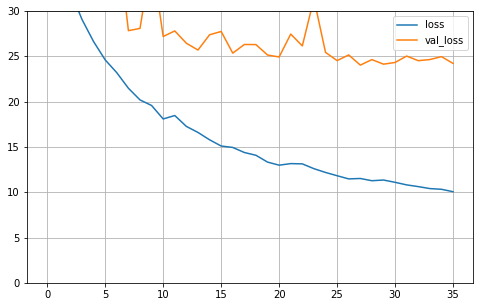

In [35]:
pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0,30)
plt.show()

## CNN

In [38]:
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense

tf.random.set_seed(20230516)
# Define the input and output dimensions
input_dim = X_train.shape[1]
output_dim = 1

# Input layer
input_layer = Input(shape=(input_dim, 1))

# Layer 1: Convolutional layer
conv1 = Conv1D(filters=16, kernel_size=3, activation='relu')(input_layer)
pool1 = MaxPooling1D(pool_size=4)(conv1)

# Layer 2: Convolutional layer
conv2 = Conv1D(filters=16, kernel_size=3, activation='relu')(pool1)
pool2 = MaxPooling1D(pool_size=4)(conv2)


# Layer 3: Convolutional layer
conv3 = Conv1D(filters=16, kernel_size=3, activation='relu')(pool2)
pool3 = MaxPooling1D(pool_size=4)(conv3)


# Layer 3: Convolutional layer
conv4 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool3)
pool4 = MaxPooling1D(pool_size=4)(conv4)


# Layer 4: Flatten layer and Dense layer
flatten = Flatten()(pool4)
dense1 = Dense(100, activation='relu')(flatten)
# dense2 = Dense(100, activation='relu')(dense1)
output_layer = Dense(output_dim)(dense1)

# Create the model
CNN_model = Model(inputs=input_layer, outputs=output_layer)

# # Compile the model with appropriate loss function for regression
CNN_model.compile(loss="mean_squared_error",
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=["MeanSquaredError"])
# Print the model summary
CNN_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 109598, 1)]       0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 109596, 16)        64        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27399, 16)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 27397, 16)         784       
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 6849, 16)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 6847, 16)          784       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 1711, 16)          0   

In [37]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [39]:
# define the checkpoint
filepath = "/mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

# fit the model
history = CNN_model.fit(X_train,y_train,epochs=50,validation_data = (X_val, y_val),callbacks=callbacks_list)

2023-05-24 14:58:45.702369: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.


Epoch 1/50
754/754 [==============================] - 259s 343ms/step - loss: 93.1609 - mean_squared_error: 93.1609 - val_loss: 55.2592 - val_mean_squared_error: 55.2592

Epoch 00001: val_loss improved from inf to 55.25920, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5
Epoch 2/50
754/754 [==============================] - 256s 340ms/step - loss: 49.9749 - mean_squared_error: 49.9749 - val_loss: 46.5511 - val_mean_squared_error: 46.5511

Epoch 00002: val_loss improved from 55.25920 to 46.55114, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5
Epoch 3/50
754/754 [==============================] - 258s 342ms/step - loss: 44.4954 - mean_squared_error: 44.4954 - val_loss: 42.8860 - val_mean_squared_error: 42.8860

Epoch 00003: val_loss improved from 46.55114 to 42.88605, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5
Epoch 4/50
754/754 [==============================] - 257s 341ms/step - loss: 38.4136 - me

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



754/754 [==============================] - 265s 352ms/step - loss: 17.8103 - mean_squared_error: 17.8103 - val_loss: 26.6808 - val_mean_squared_error: 26.6808

Epoch 00018: val_loss improved from 27.61962 to 26.68076, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5
Epoch 19/50
754/754 [==============================] - 264s 350ms/step - loss: 16.9675 - mean_squared_error: 16.9675 - val_loss: 27.1857 - val_mean_squared_error: 27.1857

Epoch 00019: val_loss did not improve from 26.68076
Epoch 20/50
754/754 [==============================] - 264s 351ms/step - loss: 15.7913 - mean_squared_error: 15.7913 - val_loss: 27.8271 - val_mean_squared_error: 27.8271

Epoch 00020: val_loss did not improve from 26.68076
Epoch 21/50
754/754 [==============================] - 265s 351ms/step - loss: 14.7450 - mean_squared_error: 14.7450 - val_loss: 27.9884 - val_mean_squared_error: 27.9884

Epoch 00021: val_loss did not improve from 26.68076
Epoch 22/50
754/754 [=============

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



754/754 [==============================] - 267s 354ms/step - loss: 7.9685 - mean_squared_error: 7.9685 - val_loss: 24.8927 - val_mean_squared_error: 24.8927

Epoch 00039: val_loss did not improve from 23.87150
Epoch 40/50
754/754 [==============================] - 267s 354ms/step - loss: 7.3745 - mean_squared_error: 7.3745 - val_loss: 23.8324 - val_mean_squared_error: 23.8324

Epoch 00040: val_loss improved from 23.87150 to 23.83238, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/cnn_train_20230516.h5
Epoch 41/50
754/754 [==============================] - 268s 355ms/step - loss: 7.2809 - mean_squared_error: 7.2809 - val_loss: 25.1220 - val_mean_squared_error: 25.1220

Epoch 00041: val_loss did not improve from 23.83238
Epoch 42/50
754/754 [==============================] - 268s 355ms/step - loss: 7.1035 - mean_squared_error: 7.1035 - val_loss: 23.2816 - val_mean_squared_error: 23.2816

Epoch 00042: val_loss improved from 23.83238 to 23.28164, saving model to /mnt/ML_HBLUP/NA_RM1

In [42]:
# output prediction result
metrics = pred_rmse_corr(CNN_model,'CNN_hapCat',X_train,y_train,X_val,y_val,X_test,y_test,metrics)
metrics

2023-05-24 18:45:30.833235: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 21131371184 exceeds 10% of free system memory.


,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.305420,4.553930,4.440251,0.983027,0.932513,0.933978
0,DNN_hapCat,3.037271,4.901777,4.718805,0.969738,0.921050,0.925132
0,CNN_hapCat,2.431327,4.825105,4.765306,0.981043,0.923493,0.923521


In [43]:
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.305420,4.553930,4.440251,0.983027,0.932513,0.933978
0,DNN_hapCat,3.037271,4.901777,4.718805,0.969738,0.921050,0.925132
0,CNN_hapCat,2.431327,4.825105,4.765306,0.981043,0.923493,0.923521


# try probability model

In [44]:
# read in female data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_female.rds') # also works for RData
# done! 
# result is a dictionary where keys are the name of objects and the values python
# objects. In the case of Rds there is only one object with None as key
femaleData = result[None] # extract the pandas data frame 

# read in male data
result = pyreadr.read_r('/mnt/ML_HBLUP/NA_RM105_110_115/data/astProb_male.rds') # also works for RData
maleData = result[None] # extract the pandas data frame 

In [45]:
# add suffix
femaleData.columns += '_f'
maleData.columns += '_m'

In [46]:
# construct haplotype data for test and train data
trainHap = pd.concat([femaleData.loc[trainPheno['FEMALE'],:].reset_index(drop=True),
                      maleData.loc[trainPheno['MALE'],:].reset_index(drop=True)],axis=1)
trainHap = trainHap / 2

testHap = pd.concat([femaleData.loc[testPheno['FEMALE'],:].reset_index(drop=True),
                     maleData.loc[testPheno['MALE'],:].reset_index(drop=True)],axis=1)
testHap = testHap / 2

In [47]:
print(trainHap.shape)
print(testHap.shape)

(33475, 109598)
(7307, 109598)


In [48]:
trainHap.head()

,HB1__1067-1_f,HB1__32843_f,HB1__64DWA2_f,HB1__B73_f,HB1__MANS_f,HB1__NA_f,HB1__WDAQ2_f,HB2__1067-1_f,HB2__32843_f,HB2__64DWA2_f,...,HB17114__OH07_m,HB17114__PH207_m,HB17115__LH123_m,HB17115__NA_m,HB17115__OH07_m,HB17115__TA1180_m,HB17116__LH123_m,HB17116__NA_m,HB17116__OH07_m,HB17116__PH207_m
0,0.0,0.0,0.0,0.49665,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.49975,0.0,0.0,0.00000,0.49965,0.0,0.00000
1,0.5,0.0,0.0,0.00000,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.48405,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.48175
2,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.46920,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.46515
3,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.00000
4,0.0,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.49055,0.00000,0.0,0.0,0.48965,0.00000,0.0,0.00000


In [49]:
# splite the train data into train, validationa and test
seed = 20230510
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(trainHap, trainPheno['YLD_BE_BLUP'], test_size=0.1, random_state=seed)

seed = 20230515
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=seed)

In [50]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(24101, 109598)
(6026, 109598)
(3348, 109598)


In [52]:
del trainHap; del result; del femaleData; del maleData

## HapProb - LightGBM

In [54]:
gbm = lgb.LGBMRegressor(num_leaves=30,
                        learning_rate=0.1,
                        n_estimators=900,
                       bagging_fraction =  0.7,
                       feature_fraction = 0.5,
                       objective = "regression")

gbm.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mse',
        callbacks=[lgb.early_stopping(8)])

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
Training until validation scores don't improve for 8 rounds
Early stopping, best iteration is:
[826]	valid_0's l2: 19.6989


LGBMRegressor(bagging_fraction=0.7, feature_fraction=0.5, n_estimators=900,
              num_leaves=30, objective='regression')

In [55]:
# output prediction result
metrics = pred_rmse_corr(gbm,'LightGBM_hapProb',X_train,y_train,X_val,y_val,X_test,y_test,metrics)
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.305420,4.553930,4.440251,0.983027,0.932513,0.933978
0,DNN_hapCat,3.037271,4.901777,4.718805,0.969738,0.921050,0.925132
0,CNN_hapCat,2.431327,4.825105,4.765306,0.981043,0.923493,0.923521
0,LightGBM_hapProb,1.858630,4.438347,4.368822,0.989040,0.935968,0.936030


In [56]:
# save model
gbm.booster_.save_model('/mnt/ML_HBLUP/NA_RM105_110_115/models/lgbr_hapProb_30_900.txt')

# load model later
    #model = lightgbm.Booster(model_file='file.txt')
    #model.predict(predict[num_columns])

## HapProb - DNN

In [58]:
tf.random.set_seed(20230516)

DL_model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train.shape[1]], name = 'input_layer'),
    keras.layers.Dense(100, activation="relu", name = 'hidden_layer1'),
    keras.layers.Dense(300, activation="relu", name = 'hidden_layer2'),
    keras.layers.Dense(1, name = 'output_layer')
])

DL_model.compile(loss="mean_squared_error",optimizer=tf.keras.optimizers.Adam(0.001)) 

# define the checkpoint
filepath = "/mnt/ML_HBLUP/NA_RM105_110_115/models/hapProb_dnn_train_20230516.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = keras.callbacks.EarlyStopping(patience=8,restore_best_weights=True)
callbacks_list = [checkpoint,early_stopping]

# fit the model
history = DL_model.fit(X_train,y_train,epochs=50,validation_data = (X_val, y_val),callbacks=callbacks_list)

Epoch 1/50
754/754 [==============================] - 28s 36ms/step - loss: 65.6610 - val_loss: 43.0543

Epoch 00001: val_loss improved from inf to 43.05433, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/hapProb_dnn_train_20230516.h5
Epoch 2/50
754/754 [==============================] - 22s 29ms/step - loss: 36.4347 - val_loss: 37.8520

Epoch 00002: val_loss improved from 43.05433 to 37.85203, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/hapProb_dnn_train_20230516.h5
Epoch 3/50
754/754 [==============================] - 22s 29ms/step - loss: 32.2113 - val_loss: 33.0789

Epoch 00003: val_loss improved from 37.85203 to 33.07889, saving model to /mnt/ML_HBLUP/NA_RM105_110_115/models/hapProb_dnn_train_20230516.h5
Epoch 4/50
754/754 [==============================] - 22s 29ms/step - loss: 27.5528 - val_loss: 34.2083

Epoch 00004: val_loss did not improve from 33.07889
Epoch 5/50
754/754 [==============================] - 21s 29ms/step - loss: 25.7842 - val_loss: 30.4359

Ep

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [59]:
# output prediction result
metrics = pred_rmse_corr(DL_model,'DNN_hapProb',X_train,y_train,X_val,y_val,X_test,y_test,metrics)
metrics

,Method,RMSE_train,RMSE_val,RMSE_test,corr_train,corr_val,corr_test
0,LightGBM_hapCat,2.305420,4.553930,4.440251,0.983027,0.932513,0.933978
0,DNN_hapCat,3.037271,4.901777,4.718805,0.969738,0.921050,0.925132
0,CNN_hapCat,2.431327,4.825105,4.765306,0.981043,0.923493,0.923521
0,LightGBM_hapProb,1.858630,4.438347,4.368822,0.989040,0.935968,0.936030
0,DNN_hapProb,2.802485,4.746036,4.597196,0.974389,0.926110,0.928817


In [39]:
# predict 2021 test blup
pred_2021 = gbm.predict(testHap)
rmse_2021 = mean_squared_error(testPheno['YLD_BE_BLUP'], pred_2021, squared=False)
corr_2021, p_value_2021 = pearsonr(testPheno['YLD_BE_BLUP'].ravel(), pred_2021.ravel())


In [40]:
print(rmse_2021)
print(corr_2021)

18.195141085398273
0.10279315746934109
